In [6]:
# activation for openMP by setting the number of threads
import os
os.environ["OMP_NUM_THREADS"] = "8"  # number of threads
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel

from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import numpy as np
from scipy.sparse.linalg import eigsh  # Sparse eigenvalue solver

import matplotlib.pyplot as plt


In [7]:
# Parameters
n_x = 4  # lattice size in x 
n_y = 6  # lattice size in y
J = 1.0  # coupling constant
#chi = 0.9 # anisotropy
num_eigenvalues = 2 # number of eigenvalues that should be calculated (starting from the ground state)

L = n_x * n_y  # total number of spins
hz =0.0
hy = 0.0


In [8]:
# Site index mapping with periodic boundary conditions
def site(x, y):
    return (x % n_x) + n_x * (y % n_y)

# Generate all nearest-neighbor bonds without double-counting
J_ij = []
seen_bonds = set()  # use set to avoid douple counting

for x in range(n_x):
    for y in range(n_y):
        i = site(x, y)
        
        # periodic boundary conditions
        right = site(x+1, y)  # neighbor reight
        up = site(x, y+1)     # upper neighbor
        
        bond_right = tuple(sorted((i, right)))  # sort the indices
        bond_up = tuple(sorted((i, up)))

        if bond_right not in seen_bonds:
            J_ij.append([J, i, right])
            seen_bonds.add(bond_right)

        if bond_up not in seen_bonds:
            J_ij.append([J, i, up])
            seen_bonds.add(bond_up)

print(J_ij)

# 4x4 lattice with PBC
# J_ij = [[1.0, 0, 1], [1.0, 0, 4], [1.0, 4, 5], [1.0, 4, 8], [1.0, 8, 9], [1.0, 8, 12], [1.0, 12, 13], [1.0, 12, 0], 
#     [1.0, 1, 2], [1.0, 1, 5], [1.0, 5, 6], [1.0, 5, 9], [1.0, 9, 10], [1.0, 9, 13], [1.0, 13, 14], [1.0, 13, 1], 
#     [1.0, 2, 3], [1.0, 2, 6], [1.0, 6, 7], [1.0, 6, 10], [1.0, 10, 11], [1.0, 10, 14], [1.0, 14, 15], [1.0, 14, 2], 
#     [1.0, 3, 0], [1.0, 3, 7], [1.0, 7, 4], [1.0, 7, 11], [1.0, 11, 8], [1.0, 11, 15], [1.0, 15, 12], [1.0, 15, 3]]



[[1.0, 0, 1], [1.0, 0, 4], [1.0, 4, 5], [1.0, 4, 8], [1.0, 8, 9], [1.0, 8, 12], [1.0, 12, 13], [1.0, 12, 16], [1.0, 16, 17], [1.0, 16, 20], [1.0, 20, 21], [1.0, 20, 0], [1.0, 1, 2], [1.0, 1, 5], [1.0, 5, 6], [1.0, 5, 9], [1.0, 9, 10], [1.0, 9, 13], [1.0, 13, 14], [1.0, 13, 17], [1.0, 17, 18], [1.0, 17, 21], [1.0, 21, 22], [1.0, 21, 1], [1.0, 2, 3], [1.0, 2, 6], [1.0, 6, 7], [1.0, 6, 10], [1.0, 10, 11], [1.0, 10, 14], [1.0, 14, 15], [1.0, 14, 18], [1.0, 18, 19], [1.0, 18, 22], [1.0, 22, 23], [1.0, 22, 2], [1.0, 3, 0], [1.0, 3, 7], [1.0, 7, 4], [1.0, 7, 11], [1.0, 11, 8], [1.0, 11, 15], [1.0, 15, 12], [1.0, 15, 19], [1.0, 19, 16], [1.0, 19, 23], [1.0, 23, 20], [1.0, 23, 3]]


In [ ]:
def functtion_Ham(hz,chi,basiss):
    J_zz = [[ j[0], j[1], j[2]] for j in J_ij]
    J_pm = [[chi *  0.5 * j[0], j[1], j[2]] for j in J_ij] 

    # add magnetic field 
    hz = np.array([hz*(-1)**(i+j) for i in range(n_x) for j in range(n_y)])
    #hz = np.array([hz for i in range(n_x) for j in range(n_y)])
    hz = hz.reshape(n_x, n_y).T
    hz = hz.reshape(-1)
    h_z = [[hz[i], i] for i in range(L)]
    #print("magnetic filed",h_z)
    # create full basis
    #basiss = spin_basis_1d(L)   # complete basis set
    # create the hamiltonian as a sparse matrix
    static = [["+-", J_pm], ["-+", J_pm],["zz", J_zz], ["z", h_z]]

    H_sparse = hamiltonian(static, [], basis=basiss, dtype=np.float64, check_symm=False, check_pcon=False, check_herm=False).tocsr()   # Hamiltonian als sparse Matrix erstellen
    return H_sparse



: 

In [ ]:
basis_total = spin_basis_1d(L,pauli=0)   # complete basis set
print('full basis=',basis_total.Ns)
basis_biggest_block=spin_basis_1d(L,m=0,pauli=0)
print("biggest block=",basis_biggest_block.Ns)
bais_second_biggest_block1=spin_basis_1d(L,Nup=L//2+1,pauli=0)
print("second biggest block=",bais_second_biggest_block1.Ns)
bais_second_biggest_block2=spin_basis_1d(L,Nup=L//2-1,pauli=0)
print("second biggest block=",bais_second_biggest_block2.Ns)

N_chi=11
tolerance=1e-18

E_tot=np.zeros((N_chi,num_eigenvalues))
E_big_block=np.zeros((N_chi,num_eigenvalues))
E1_second_biggest=np.zeros((N_chi,num_eigenvalues))
E2_second_biggest=np.zeros((N_chi,num_eigenvalues))

chi_lar=[]

for i in range(0,N_chi,1):
    chi=0.01*i
    chi_lar.append(chi)
    print("loop for chi=",chi," started")
    #H_tot=functtion_Ham(hz,chi,basis_total)
    H_bigest_subblock=functtion_Ham(hz,chi,basis_biggest_block)
    H1_second_biggest_subblock=functtion_Ham(hz,chi,bais_second_biggest_block1)
    H2_second_biggest_subblock=functtion_Ham(hz,chi,bais_second_biggest_block2)

    #eigenvalues,eigenvectors = eigsh(H_tot, k=num_eigenvalues, which='SA', tol=tolerance)   # 'SA' -> smallest algebraic eigenvalue

    #eigenvalues = eigsh(H_tot, k=num_eigenvalues, which='SA', tol=tolerance)[0]
    #E_tot[i]=eigenvalues

    #eigenvalues_biggest_sub,eigenvectors_biggest_sub = eigsh(H_bigest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)

    eigenvalues_biggest_sub= eigsh(H_bigest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)[0]

    E_big_block[i]=eigenvalues_biggest_sub

    #eigenvalues1_second_big_subblock,eigenvectors_second1 = eigsh(H1_second_biggest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)

    eigenvalues1_second_big_subblock = eigsh(H1_second_biggest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)[0]

    E1_second_biggest[i]=eigenvalues1_second_big_subblock
    
    #eigenvalues2_second_big_subblock,eigenvectors_second2 = eigsh(H2_second_biggest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)
    
    eigenvalues2_second_big_subblock = eigsh(H2_second_biggest_subblock, k=num_eigenvalues, which='SA', tol=tolerance)[0]

    E2_second_biggest[i]=eigenvalues2_second_big_subblock


    


full basis= 16777216
biggest block= 2704156
second biggest block= 2496144
second biggest block= 2496144
loop for chi= 0.0  started
loop for chi= 0.01  started


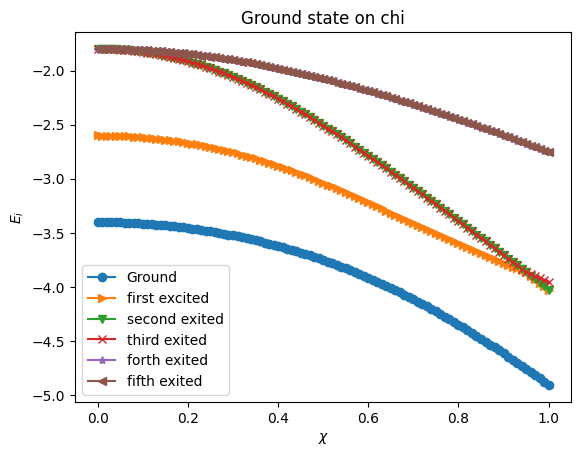

In [ ]:



#plt.plot(chi_lar,E_tot[:,0],"o",linestyle="solid",label="Ground")

#plt.plot(chi_lar,E_tot[:,1],">",linestyle="solid",label="first excited")


#plt.plot(chi_lar,E_tot[:,2],"v",linestyle="solid",label="second exited")

#plt.plot(chi_lar,E_tot[:,3],"x",linestyle="solid",label="third exited")

#plt.plot(chi_lar,E_tot[:,4],"*",linestyle="solid",label="forth exited")

#plt.plot(chi_lar,E_tot[:,4],"<",linestyle="solid",label="fifth exited")



#plt.title("Ground state on chi")
#plt.ylabel(r"$E_i$")
#plt.xlabel(r"$\chi$")
#plt.legend(loc='best')
#plt.show()

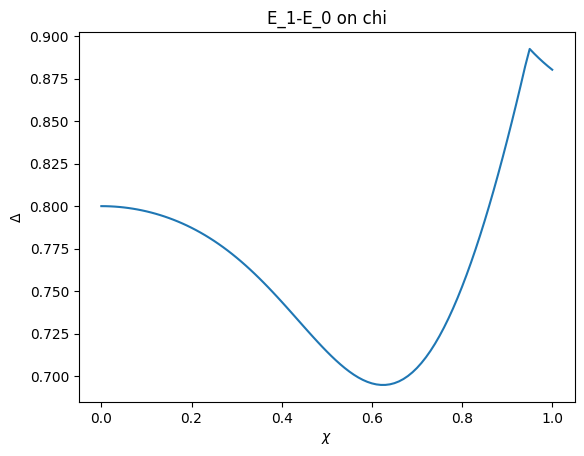

In [ ]:

#plt.plot(chi_lar,E_tot[:,1]-E_tot[:,0])
#plt.title("E_1-E_0 on chi")
#plt.ylabel(r"$\Delta $")
#plt.xlabel(r"$\chi$")
#plt.show()

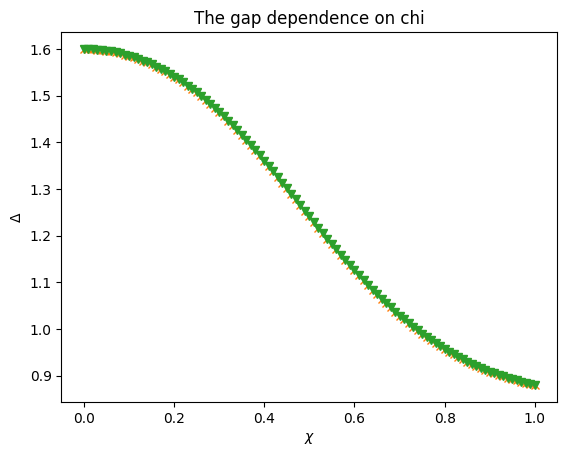

In [ ]:
plt.plot(chi_lar,E1_second_biggest[:,0]-E_big_block[:,0])

plt.plot(chi_lar,E2_second_biggest[:,0]-E_big_block[:,0],'x')

#plt.plot(chi_lar,E1_second_biggest[:,0]-E_tot[:,0],"v")



plt.title("The gap dependence on chi")
plt.ylabel(r"$\Delta $")
plt.xlabel(r"$\chi$")
plt.show()